<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*

# Global and Local Spatial Autocorrelation

__Gunther Gust__ <br>
Chair for Enterprise AI <br>
Data Driven Decisions Group

Winter Semester 23/24

<img src="images/d3.png" style="width:20%; float:left;" />

## Content

- Theoretical Background
- Global Spatial Autocorrelation
- Local Spatial Autocorrelation

*Credits: Most of the material is taken from [Arribas-Bel, Geographic Data Science](https://darribas.org/gds_course/content/home.html#)*

In [20]:
from IPython.display import YouTubeVideo, IFrame
IFrame("https://liverpool.instructuremedia.com/embed/f95a8c1e-f701-4bd0-adde-093fbfbb4881",
       width=500,
       height=300
      )

Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. Not completely unlike the traditional correlation between two variables -which informs us about how the values in one variable change as a function of those in the other- and analogous to its time-series counterpart -which relates the value of a variable at a given point in time with those in previous periods-, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in surrounding locations.

A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if it is distributed following no discernible pattern over space. Spatial autocorrelation can thus be formally defined as the "absence of spatial randomness", which gives room for two main classes of autocorrelation, similar to the traditional case: *positive* spatial autocorrelation, when similar values tend to group together in similar locations; and *negative* spatial autocorrelation, in cases where similar values tend to be dispersed and further apart from each other.

In this session we will learn how to explore spatial autocorrelation in a given dataset, interrogating the data about its presence, nature, and strength. To do this, we will use a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA), specifically designed for this purpose. The range of ESDA methods is very wide and spans from less sophisticated approaches like choropleths and general table querying, to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical dimension of the data. The purpose of this session is to dip our toes into the latter group.

ESDA techniques are usually divided into two main groups: tools to analyze *global*, and *local* spatial autocorrelation. The former consider the overall trend that the location of values follows, and makes possible statements about the degree of *clustering* in the dataset. *Do values generally follow a particular pattern in their geographical distribution*? *Are similar values closer to other similar values than we would expect from pure chance?* These are some of the questions that tools for global spatial autocorrelation allow to answer. We will practice with global spatial autocorrelation by using Moran's I statistic.

Tools for *local* spatial autocorrelation instead focus on spatial instability: the departure of parts of a map from the general trend. The idea here is that, even though there is a given trend for the data in terms of the nature and strength of spatial association, some particular areas can diverege quite substantially from the general pattern. Regardless of the overall degree of concentration in the values, we can observe pockets of unusually high (low) values close to other high (low) values, in what we will call hot(cold)spots. Additionally, it is also possible to observe some high (low) values surrounded by low (high) values, and we will name these "spatial outliers". The main technique we will review in this session to explore local spatial autocorrelation is the Local Indicators of Spatial Association (LISA).

In [21]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

## Data

For this session, we will use the results of the __2016 referendum vote to leave the EU__, at the local authority level. In particular, we will focus on the spatial distribution of the vote to Leave, which ended up winning. From a technical point of view, you will be working with polygons which have a value (the percentage of the electorate that voted to Leave the EU) attached to them.

All the necessary data have been assembled for convenience in a single file that contains geographic information about each local authority in England, Wales and Scotland, as well as the vote attributes. The file is in the geospatial format [GeoPackage](http://www.geopackage.org/), which presents several advantages over the more traditional shapefile (chief among them, the need of a single file instead of several). The file is available as a download from the course website.

````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [22]:
# Read the file in
br = gpd.read_file(
    "https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/brexit.gpkg"
)

Alternative: 
Instead of reading the file directly off the web, it is possible to download it manually, store it on your computer, and read it locally. To do that, you can follow these steps:
1. Download the file by browsing to the github repository "sc_gdsa_data"
1. Place the file on the _same folder as the notebook_ where you intend to read it
1. Replace the code in the cell above by: `br = gpd.read_file("brexit.gpkg")`


Now let's index it on the local authority IDs, while keeping those as a column too:

In [23]:
# Index table on the LAD ID
br = br.set_index("lad16cd", drop=False)
# Display summary
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16cd    380 non-null    object  
 2   lad16nm    380 non-null    object  
 3   Pct_Leave  380 non-null    float64 
 4   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 25.9+ KB


In [24]:
br.head()

,objectid,lad16cd,lad16nm,Pct_Leave,geometry
lad16cd,,,,,
E06000001,1,E06000001,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.27250 54..."
E06000002,2,E06000002,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.23431 54..."
E06000003,3,E06000003,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13717 54.64693, -1.13746 54..."
E06000004,4,E06000004,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-1.31774 54.64524, -1.31869 54..."
E06000005,5,E06000005,Darlington,56.18,"POLYGON ((-1.63799 54.61719, -1.64077 54.61739..."


Let's get a first view of the data using a choropleth:

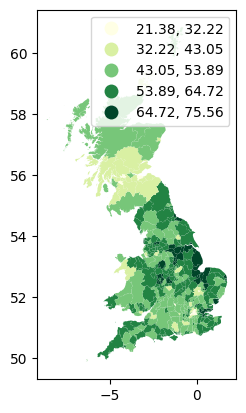

In [25]:
ax = br.plot(column="Pct_Leave", scheme="equal_interval", cmap="YlGn", legend = True)

## Preparing the data

### Spatial weights matrix

As discused before, a spatial weights matrix is the way geographical space is formally encoded into a numerical form so it is easy for a computer (or a statistical method) to understand. We have seen already many of the conceptual ways in which we can define a spatial weights matrix, such as contiguity, distance-based, or block.

For this example, we will show how to build a queen contiguity matrix, which considers two observations as neighbors if they share at least one point of their boundary. In other words, for a pair of local authorities in the dataset to be considered neighbours under this $W$, they will need to be sharing border or, in other words, "touching" each other to some degree.

Technically speaking, we will approach building the contiguity matrix in the same way we did in Lab 5. We will begin with a `GeoDataFrame` and pass it on to the queen contiguity weights builder in `PySAL` (`ps.weights.Queen.from_dataframe`). We will also make sure our table of data is previously indexed on the local authority code, so the $W$ is also indexed on that form.

In [26]:
# Create the spatial weights matrix
w = weights.Queen.from_dataframe(br, ids="lad16cd")

C:\Users\ggust\anaconda3\envs\sc_gsda_l6\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: E06000046, E06000053, S12000013, S12000023, S12000027, W06000001.
  warnings.warn(message)


Now, the `w` object we have just is of the same type of any other one we have created in the past. As such, we can inspect it in the same way. For example, we can check who is a neighbor of observation `E08000012`:

In [27]:
w['E08000012']

{'E08000011': 1.0, 'E06000006': 1.0, 'E08000014': 1.0}

However, the cell where we computed $W$ returned a warning on "islands". Remember these are islands not necessarily in the geographic sense (although some of them will be), but in the mathematical sense of the term: local authorities that are not sharing border with any other one and thus do not have any neighbors. We can inspect and map them to get a better sense of what we are dealing with:

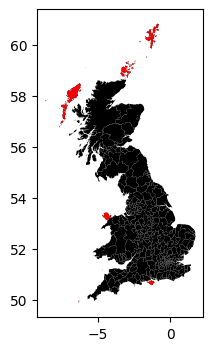

In [28]:
ax = br.plot(color='k', figsize=(4,4))
br.loc[w.islands, :].plot(color='red', ax=ax);

In this case, all the islands are indeed "real" islands. These cases can create issues in the analysis and distort the results. There are several solutions to this situation such as connecting the islands to other observations through a __different criterium (e.g. nearest neighbor)__, and then combining both spatial weights matrices. 

For convenience, we will __remove__ them from the dataset because they are a small sample and their removal is likely not to have a large impact in the calculations.

Technically, this amounts to a subsetting, very much like we saw in the first weeks of the course, although in this case we will use the `drop` command, which comes in very handy in these cases:

In [29]:
br = br.drop(w.islands)

Once we have the set of local authorities that are not an island, we need to re-calculate the weights matrix:

In [30]:
# Create the spatial weights matrix
w = weights.Queen.from_dataframe(br, ids="lad16cd")

And, finally, let us row-standardize it to make sure every row of the matrix sums up to one:

In [31]:
# Row standardize the matrix
w.transform = 'R'

Now, because we have row-standardize them, the weight given to each of the three neighbors is 0.33 which, all together, sum up to one.

In [32]:
w['E08000012']

{'E08000011': 0.3333333333333333,
 'E06000006': 0.3333333333333333,
 'E08000014': 0.3333333333333333}

### Spatial lag

Once we have the data and the spatial weights matrix ready, we can start by computing the spatial lag of the percentage of votes that went to leave the EU. Remember the spatial lag is the product of the spatial weights matrix and a given variable and that, if $W$ is row-standardized, the result amounts to the average value of the variable in the neighborhood of each observation.

We can calculate the spatial lag for the variable `Pct_Leave` and store it directly in the main table with the following line of code:

In [33]:
br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

Let us have a quick look at the resulting variable, as compared to the original one:

In [34]:
br[['lad16cd', 'lad16nm','Pct_Leave', 'w_Pct_Leave']].head()

,lad16cd,lad16nm,Pct_Leave,w_Pct_Leave
lad16cd,,,,
E06000001,E06000001,Hartlepool,69.57,59.640000
E06000002,E06000002,Middlesbrough,65.48,60.526667
E06000003,E06000003,Redcar and Cleveland,66.19,60.376667
E06000004,E06000004,Stockton-on-Tees,61.73,60.488000
E06000005,E06000005,Darlington,56.18,57.430000


The way to interpret the spatial lag (`w_Pct_Leave`) for say the first observation is as follow: Hartlepool, where 69,6% of the electorate voted to leave is surrounded by neighbouring local authorities where, on average, almost 60% of the electorate also voted to leave the EU. 

For the purpose of illustration, we can in fact check this is correct by querying the spatial weights matrix to find out Hartepool's neighbors: 

In [35]:
w.neighbors['E06000001']

['E06000004', 'E06000047']

And then checking their values:

In [36]:
neis = br.loc[w.neighbors['E06000001'], 'Pct_Leave']
neis

lad16cd
E06000004    61.73
E06000047    57.55
Name: Pct_Leave, dtype: float64

And the average value, which we saw in the spatial lag is 61.8, can be calculated as follows:

In [37]:
neis.mean()

59.64

For some of the techniques we will be seeing below, it makes more sense to operate with the __standardized version__ of a variable, rather than with the raw one. Standardizing means to substract the average value and divide by the standard deviation each observation of the column. This can be done easily with a bit of basic algebra in Python:

In [38]:
br['Pct_Leave_std'] = (
    br['Pct_Leave'] - br['Pct_Leave'].mean()
) / br['Pct_Leave'].std()

Finally, to be able to explore the spatial patterns of the standardized values, also called sometimes $z$ values, we need to create its spatial lag:

In [39]:
br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])

## Global Spatial autocorrelation



Global spatial autocorrelation relates to the overall geographical pattern present in the data. Statistics designed to measure this trend thus characterize a map in terms of its degree of clustering and summarize it. This summary can be visual or numerical. In this section, we will walk through an example of each of them: the Moran Plot, and Moran's I statistic of spatial autocorrelation.

### Moran Plot



The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by substracting its mean and dividing it by its standard deviation.

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot in Python, provided we have standardized the variable and calculated its spatial lag beforehand:

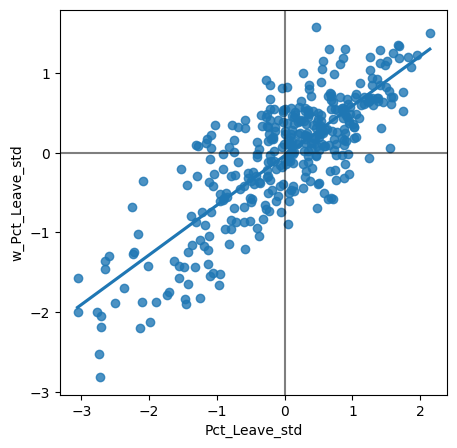

In [40]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

The figure above displays the relationship between the standardized percentage which voted to Leave the EU (`Pct_Leave_std`) and its spatial lag which, because the $W$ that was used is row-standardized, can be interpreted as the average percentage which voted to Leave in the surrounding areas of a given Local Authority. In order to guide the interpretation of the plot, a linear fit is also included in the post. This line represents the best linear fit to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line. 

The plot displays a positive relationship between both variables. This is associated with the presence of *positive* spatial autocorrelation: similar values tend to be located close to each other. This means that the *overall trend* is for high values to be close to other high values, and for low values to be surrounded by other low values. This however does not mean that this is only situation in the dataset: there can of course be particular cases where high values are surrounded by low ones, and viceversa. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space.

In the context of the example, this can be interpreted along the lines of: local authorities display positive spatial autocorrelation in the way they voted in the EU referendum. This means that local authorities with high percentage of Leave voters tend to be located nearby other local authorities where a significant share of the electorate also voted to Leave, and viceversa.

### Moran's I



The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a __statistical measure that summarizes the figure__. This is exactly what Moran's I is meant to do. 

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is an even close connection between the two: the __value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot__.

In order to calculate Moran's I in our dataset, we can call a specific function in `PySAL` directly:

In [41]:
mi = esda.Moran(br['Pct_Leave'], w)

Note how we do not need to use the standardized version in this context as we will not represent it visually.

The method `esda.Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [42]:
mi.I

0.6228641407137806

The other bit of information we will extract from Moran's I relates to __statistical inference__: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics?

If we considered the same variable but __shuffled its locations randomly__, would we obtain a map with similar characteristics? To obtain insight into these questions, esda performs a simulation and returns a measure of certainty about how likely it is to obtain a pattern like the one we observe under a spatially random process. This is summarized in the `p_sim` attribute:

The most reliable __p-value__ for Moran's I can be found in the attribute `p_sim`:

In [43]:
mi.p_sim

0.001

That is just 0.1% and, by standard terms, it would be considered statistically significant. We can quickly ellaborate on its intuition. What that 0.001 (or 0.1%) means is that, if we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, __only 0.1%__ of them would display a __larger (absolute) value than the one we obtain from the real data__, and the other 99.9% of the random maps would receive a smaller (absolute) value of Moran's I. If we remember again that the value of Moran's I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values for the Leave votes is more concentrated than if the values had been allocated following a completely spatially random process, hence the statistical significance.


Once we have calculated Moran's I and created an object like `mi`, we can use some of the functionality in `splot` to replicate the plot above more easily:

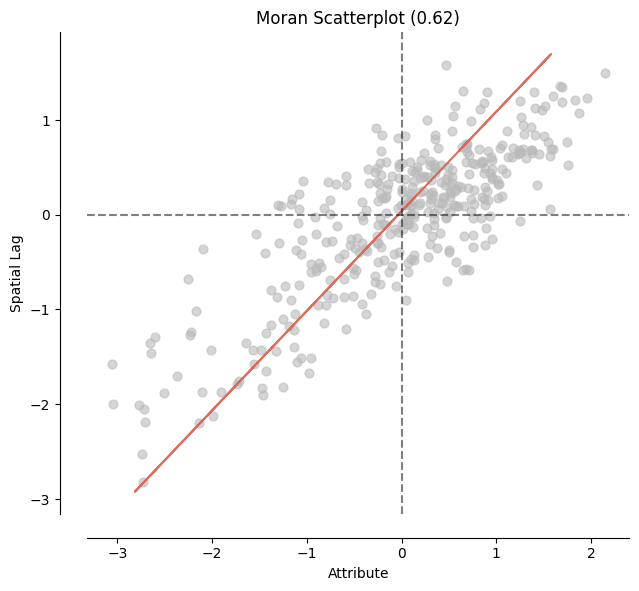

In [44]:
moran_scatterplot(mi);

As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively correlated over space. In terms of our initial goal to find spatial structure in the attitude towards Brexit, this view seems to align: if the vote had no such structure, it should not show a pattern over space -technically, it would show a random one.

## Local Spatial autocorrelation



Moran's I is good tool to summarize a dataset into a single value that informs about its degree of *clustering*. However, it is not an appropriate measure to identify areas within the map where specific values are located. In other words, Moran's I can tell us values are clustered overall, but it will not inform us about *where* the clusters are. For that purpose, we need to use a *local* measure of spatial autocorrelation. Local measures consider each single observation in a dataset and operate on them, as oposed to on the overall data, as *global* measures do. Because of that, they are not good a summarizing a map, but they allow to obtain further insight.

### LISA: Local measure of Moran's I

In this session, we will consider [Local Indicators of Spatial Association](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract) (LISAs), a local counter-part of global measures like Moran's I. At the core of these method is a classification of the observations in a dataset into four groups derived from the Moran Plot: 
* __Hotspots__: high values surrounded by high values (HH), 
* __Coldspots__: low values nearby other low values (LL), 
* __Outliers (Diamonds)__:high values among low values (HL), 
* __Outliers (Donuts)__: viceversa (LH). 

Each of these groups are typically called __"quadrants"__. 

An illustration of where each of these groups fall into the Moran Plot can be seen below:

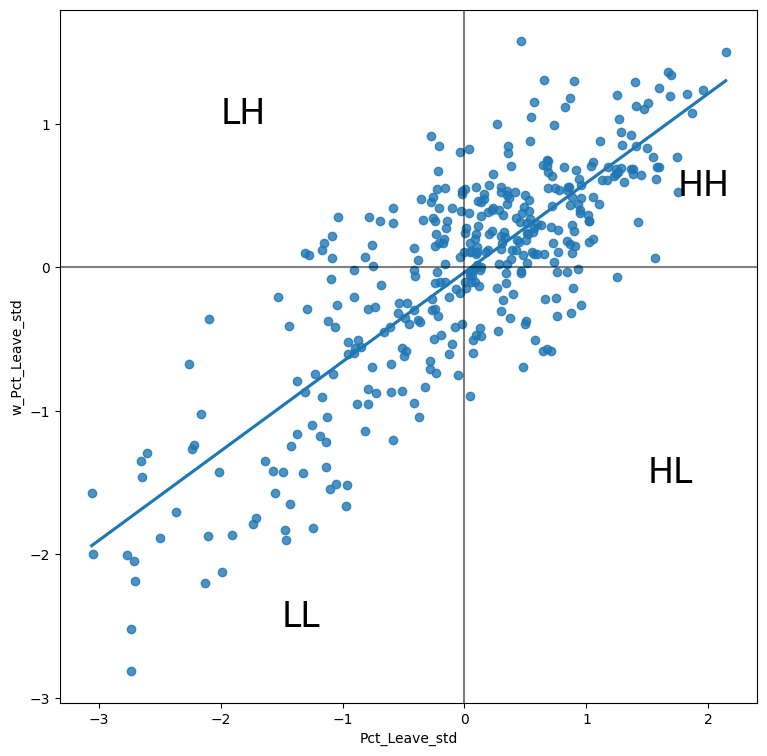

In [45]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

### Local Indicators of Spatial Associations (LISA)

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying __areas__ of __unusual concentration__ of values. 

To know whether each of the locations is a __*statistically significant* cluster__ of a given kind, we again need to __compare__ it with what we would expect if the data were allocated in a __completely random way__. 

After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high. 


This is exactly what LISAs are designed to do. As before, a more detailed description of their statistical underpinnings is beyond the scope in this context, but we will try to shed some light into the intuition of how they go about it. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as many statistics as original observations.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide *suggestive* evidence about the processes that might be at work. For that, they have a prime place in the exploratory toolbox. Examples of contexts where LISAs can be useful include: identification of spatial clusters of poverty in regions, detection of ethnic enclaves, delineation of areas of particularly high/low activity of any phenomenon, etc.

In Python, we can calculate LISAs in a very streamlined way thanks to `PySAL`:

In [46]:
lisa = esda.Moran_Local(br['Pct_Leave'], w)

All we need to pass is the variable of interest -percentage of Leave votes- and the spatial weights that describes the neighborhood relations between the different observation that make up the dataset.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember that we are calculating a statistic for every sigle observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. Instead, what is typically done is to create a map, a cluster map as it is usually called, that extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object we have created above. But, to make the map making more straightforward, it is convenient to pull them out and insert them in the main data table, `br`:

In [47]:
# Break observations into significant or not
br['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
br['quadrant'] = lisa.q

Let us stop for second on these two steps. First, the `significant` column. Similarly as with global Moran's I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran's I, we select 5% as the threshold for statistical significance. To identify these values, we create a variable, `significant`, that contains `True` if the p-value of the observation is satisfies the condition, and `False` otherwise. We can check this is the case:

In [48]:
br['significant'].head()

lad16cd
E06000001    False
E06000002    False
E06000003    False
E06000004    False
E06000005    False
Name: significant, dtype: bool

And the first five p-values can be checked by:

In [49]:
lisa.p_sim[:5]

array([0.209, 0.107, 0.113, 0.055, 0.23 ])

Note how the third and fourth are smaller than 0.05, as the variable `significant` correctly identified.

Second, the quadrant each observation belongs to. This one is easier as it comes built into the `lisa` object directly:

### Quadrants

In [50]:
br['quadrant'].head()

lad16cd
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
Name: quadrant, dtype: int32

The correspondence between the numbers in the variable and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL


We can create a quick LISA cluster map with `splot`:

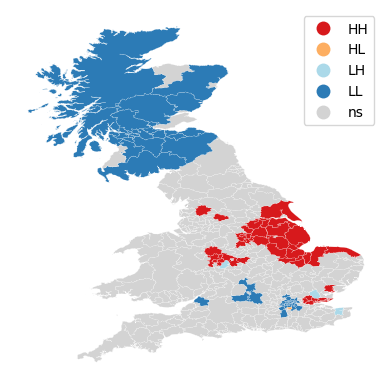

In [51]:
lisa_cluster(lisa, br);

Or, if we want to have more control over what is being displayed, and how each component is presented, we can "cook" the plot ourselves:

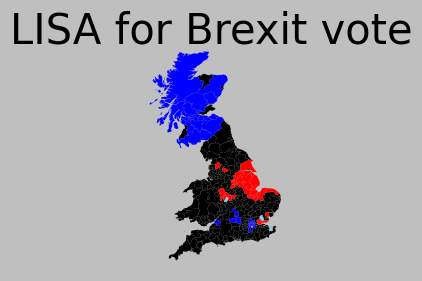

In [52]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(3, 3))
# Plot insignificant clusters
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')
# Plot HH clusters
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')
# Style and draw
f.suptitle('LISA for Brexit vote', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.show()

The map above displays the LISA results of the Brexit vote. In bright red, we find those local authorities with an unusual concentration of high Leave voters surrounded also by high levels of Leave vote. This corresponds with areas in the East of England, the Black Country, and East of London. In light red, we find the first type of *spatial outliers*. These are areas with high Leave vote but surrounded by areas with low support for leaving the EU (e.g. central London). Finally, in light blue we find the other type of spatial outlier: local authorities with low Leave support surrounded by other authorities with high support.

The substantive interpretation of a LISA map needs to relate its output to the original intention of the analyst who created the map. In this case, our original idea was to explore the spatial structure of support to leaving the EU. The LISA proves a fairly useful tool in this context. Comparing the LISA map above with the choropleth we started with, we can interpret the LISA as "simplification" of the detailed but perhaps too complicated picture in the choropleth that focuses the reader's attention to the areas that display a particularly high concentration of (dis)similar values, helping the spatial structure of the vote emerge in a more explicit way. The result of this highlights the relevance that the East of England and the Midlands had in voting to Leave, as well as the regions of the map where there was a lot less excitement about Leaving.

### Summary Plot

The results from the LISA statistics can be connected to the Moran plot to visualise where in the scatter plot each type of polygon falls:

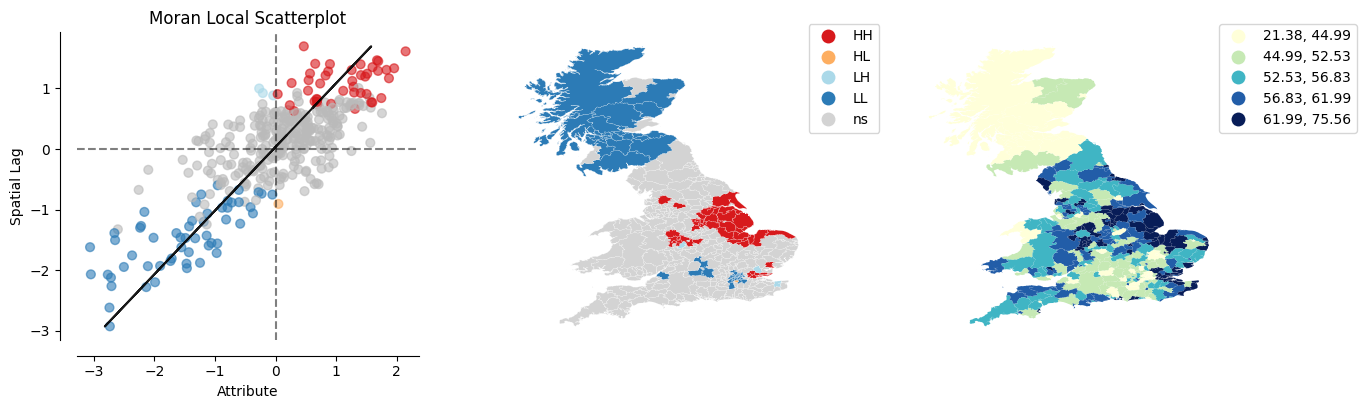

In [53]:
plot_local_autocorrelation(lisa, br, 'Pct_Leave');

<img src="images/d3.png" style="width:50%; float:center;" />